# __SNP Data Analysis__

A common application of (group) lasso is in genomics where we observe SNP data.
We focus on two applications.
The first is when the unphased calldata is provided for each individual and SNP.
The second is when the phased calldata as well as the ancestry information are provided.

In [1]:
import adelie as ad
import numpy as np
import matplotlib.pyplot as plt
import os

## __SNP Unphased__

The usual unphased calldata is a `(n, s)` matrix of type `np.int8` since the entries are one of `{0,1,2}` (assuming no missing values), where `n` is the number of observations and `s` is the number of SNPs.
We assume that the user has access to a dense matrix of the unphased calldata prior to using `adelie`.
For the purposes of demonstration, we will generate our dataset.
In practice, there are other third-party libraries such as `scikit-allel` that load the calldata
(phased / unphased) and other information from files.

To fully mimic the real application, we assume that the calldata is split into chromosomes
so that we load column-blocks of the calldata, one chromosome at a time.
We will generate `n` observations and `ss[i]` SNPs per chromosome for each chromosome `i`.

In [2]:
n = 1000                        # number of observations
ss = [1000, 2000, 3000]         # number of SNPs per chromosome (3 chromosomes)
seed = 0                        # seed
n_threads = 1                   # number of threads

We provide a helper function to generate data based on the structure of unphased calldata.
The following code iterates over the chromosomes, outputs a randomly generated unphased calldata,
and stacks them as column-blocks.

In [3]:
np.random.seed(seed)
calldatas = [
    ad.data.snp_unphased(n, s, seed=i)["X"]
    for i, s in enumerate(ss)
]
calldata = np.concatenate(calldatas, axis=-1)
calldata.shape

(1000, 6000)

Although we can technically fit lasso with this dense calldata,
it is much more efficient to exploit the sparsity of the calldata.
For this reason, we provide a special matrix class dedicated to representing unphased calldata.
It is not important for the user to know the exact representation,
but they must explicitly convert the dense matrix into this representation first before instantiating the special matrix.
For each chromosome `i`, we will convert the dense calldata and store it in `/tmp/su_chr_i.snpdat`.

In [4]:
filenames = [
    f"/tmp/su_chr_{i}.snpdat"
    for i in range(len(ss))
]
for name, dat in zip(filenames, calldatas):
    handler = ad.io.snp_unphased(name)
    handler.write(dat, n_threads=n_threads)

The following code instantiates the special matrix representing the unphased calldata.
We first create a list of SNP matrices by calling `ad.matrix.snp_unphased` for each file name.
Then, we "concatenate" them by calling `ad.matrix.concatenate`.
Note that these matrices are specially written so that they have 
the same abstract representation as `calldata`, but have different internal structures.

In [5]:
X = ad.matrix.concatenate(
    [
        ad.matrix.snp_unphased(filename, n_threads=n_threads)
        for filename in filenames
    ],
    axis=1,
    n_threads=n_threads,
)

For demonstration purposes, we generate our response vector `y` from a linear model
with only the last three SNPs active in the model.

In [6]:
np.random.seed(314)
s = int(np.sum(ss))
beta = np.random.normal(0, 1, 3)
Xb = np.zeros(n)
X.btmul(s-3, 3, beta, Xb)
y = Xb + np.random.normal(0, 1, n)

Finally, we use `adelie` to fit lasso!

In [7]:
state = ad.grpnet(
    X=X,
    glm=ad.glm.gaussian(y=y),
    n_threads=n_threads,
)

 70%|███████   | 70/100 [00:00:00<00:00:00, 363.26it/s] [dev:90.3%]


Now, we can use our diagnostic object to inspect our solutions.
For example, we can plot the coefficients.

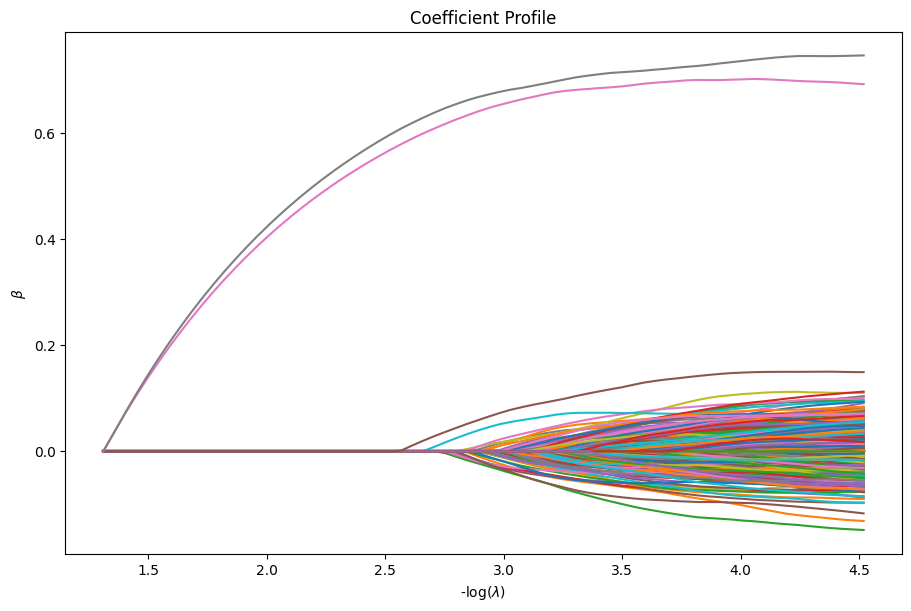

In [8]:
dg = ad.diagnostic.diagnostic(state)
dg.plot_coefficients()
plt.show()

In [9]:
# clean-up generated files!
for filename in filenames: os.remove(filename)

## __SNP Phased Ancestry__

The usual phased calldata is a `(n, 2s)` matrix of type `np.int8` since the entries are one of `{0,1}` (assuming no missing values), where `n` is the number of observations and `s` is the number of SNPs.
The factor of `2` comes from the fact that there are always 2 haplotypes.
The ancestry information is also a `(n, 2s)` matrix of type `np.int8` where each entry
takes on a value in `{0,1,..., A-1}` where `A` is the number of ancestry categories.
Each ancestry information corresponds to the individual, haplotype, and SNP as in the calldata.
We assume that the user has access to a dense matrix of the phased calldata 
and the corresponding ancestry information prior to using `adelie`.

The data matrix we ultimately want to use is the sum of the ancestry-expanded calldata for each haplotype, described next.
Fix a haplotype, and consider the corresponding calldata and ancestry matrix.
For each `(i,j)` entry of the calldata, suppose it is exanded into a length `A` vector
where a mutation is recorded in entry `k` if the ancestry at `(i,j)` is `k` (and zero otherwise).
The concatenation of all these expanded vectors results in `(n, As)` matrix.
Then, we wish to run group lasso by grouping every `A` columns as a group (i.e. SNP).

To fully mimic the real application, we assume that the calldata is split into chromosomes
so that we load column-blocks of the calldata, one chromosome at a time.
We will generate `n` observations and `ss[i]` SNPs per chromosome for each chromosome `i`.

In [10]:
n = 1000                        # number of observations
ss = [1000, 2000, 3000]         # number of SNPs per chromosome (3 chromosomes)
A = 8                           # number of ancestries
n_threads = 1                   # number of threads

Similar to the unphased calldata example,
we generate our data for each chromosome using a helper function 
and store a sparse representation in `/tmp/spa_chr_i.snpdat` for each chromosome `i`.

In [11]:
filenames = [
    f"/tmp/spa_chr_{i}.snpdat"
    for i in range(len(ss))
]
for i, s in enumerate(ss):
    data = ad.data.snp_phased_ancestry(n, s, A)
    handler = ad.io.snp_phased_ancestry(filenames[i])
    handler.write(data["X"], data["ancestries"], A, n_threads)

We then instantiate our special matrix object for phased ancestry SNP data.

In [12]:
X = ad.matrix.concatenate(
    [
        ad.matrix.snp_phased_ancestry(filename, n_threads=n_threads)
        for filename in filenames
    ],
    axis=1,
    n_threads=n_threads,
)

For demonstration purposes, we generate our response vector `y` from a linear model
with only the last three SNPs active in the model.

In [13]:
s = int(np.sum(ss))
p = A * s

np.random.seed(314)
beta = np.random.normal(0, 1, 3*A)
Xb = np.zeros(n)
X.btmul(p-3*A, 3*A, beta, Xb)
y = Xb + np.random.normal(0, 1, n)

Finally, we use `adelie` to fit group lasso!

In [14]:
state = ad.grpnet(
    X=X,
    glm=ad.glm.gaussian(y=y),
    groups=A * np.arange(s),
    n_threads=n_threads,
)

 62%|██████    | 62/100 [00:00:00<00:00:00, 182.69it/s] [dev:90.5%]


Now, we can use our diagnostic object to inspect our solutions.
For example, we can plot the coefficients.

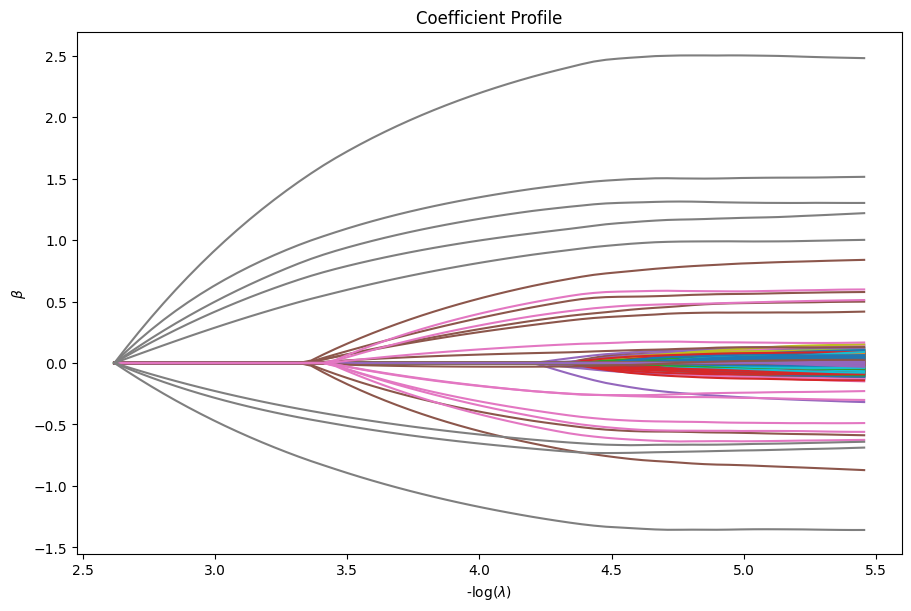

In [15]:
dg = ad.diagnostic.diagnostic(state)
dg.plot_coefficients()
plt.show()

In [16]:
# clean-up generated files!
for filename in filenames: os.remove(filename)